In [ ]:
# BUAN 6341- Applied Machine Learning 
#Group 7 
#Project 5- Mercedes Benz-Greener Manufacturing 
#Yash Tated
#Shaista

In [1]:
#import necessary libraries 
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression, SelectPercentile
from sklearn.decomposition import NMF
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the dataset
data = pd.read_csv(r'C:\Users\Admin\Machine Learning\Project 5_data.csv')

In [3]:
# Display dimensions and first few rows of the dataset
print("Dataset dimensions:", data.shape)
print(data.head())

# Check data types and missing values
print(data.info())

# Check for null values in the dataset
null_counts = data.isnull().sum()

# Display columns with null values and their counts
null_counts[null_counts > 0]

Dataset dimensions: (4209, 378)
   ID       y  X0 X1  X2 X3 X4 X5 X6 X8  ...  X375  X376  X377  X378  X379  \
0   0  130.81   k  v  at  a  d  u  j  o  ...     0     0     1     0     0   
1   6   88.53   k  t  av  e  d  y  l  o  ...     1     0     0     0     0   
2   7   76.26  az  w   n  c  d  x  j  x  ...     0     0     0     0     0   
3   9   80.62  az  t   n  f  d  x  l  e  ...     0     0     0     0     0   
4  13   78.02  az  v   n  f  d  h  d  n  ...     0     0     0     0     0   

   X380  X382  X383  X384  X385  
0     0     0     0     0     0  
1     0     0     0     0     0  
2     0     1     0     0     0  
3     0     0     0     0     0  
4     0     0     0     0     0  

[5 rows x 378 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 378 entries, ID to X385
dtypes: float64(1), int64(369), object(8)
memory usage: 12.1+ MB
None


Series([], dtype: int64)

Summary Statistics for Numeric Columns:
                ID            y          X10     X11          X12  \
count  4209.000000  4209.000000  4209.000000  4209.0  4209.000000   
mean   4205.960798   100.669318     0.013305     0.0     0.075077   
std    2437.608688    12.679381     0.114590     0.0     0.263547   
min       0.000000    72.110000     0.000000     0.0     0.000000   
25%    2095.000000    90.820000     0.000000     0.0     0.000000   
50%    4220.000000    99.150000     0.000000     0.0     0.000000   
75%    6314.000000   109.010000     0.000000     0.0     0.000000   
max    8417.000000   265.320000     1.000000     0.0     1.000000   

               X13          X14          X15          X16          X17  ...  \
count  4209.000000  4209.000000  4209.000000  4209.000000  4209.000000  ...   
mean      0.057971     0.428130     0.000475     0.002613     0.007603  ...   
std       0.233716     0.494867     0.021796     0.051061     0.086872  ...   
min       0.000000    

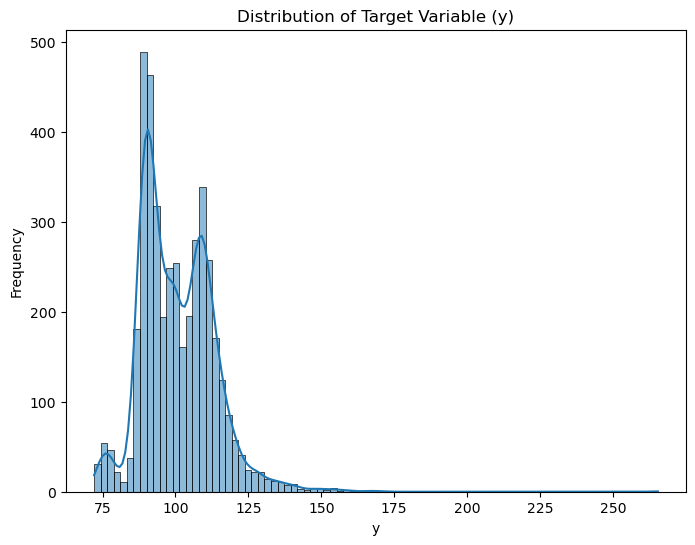

In [4]:
# Summary statistics for numeric columns
print("Summary Statistics for Numeric Columns:")
print(data.describe())

# Visualize distribution of the target variable y
plt.figure(figsize=(8, 6))
sns.histplot(data['y'], kde=True)
plt.title('Distribution of Target Variable (y)')
plt.xlabel('y')
plt.ylabel('Frequency')
plt.show()

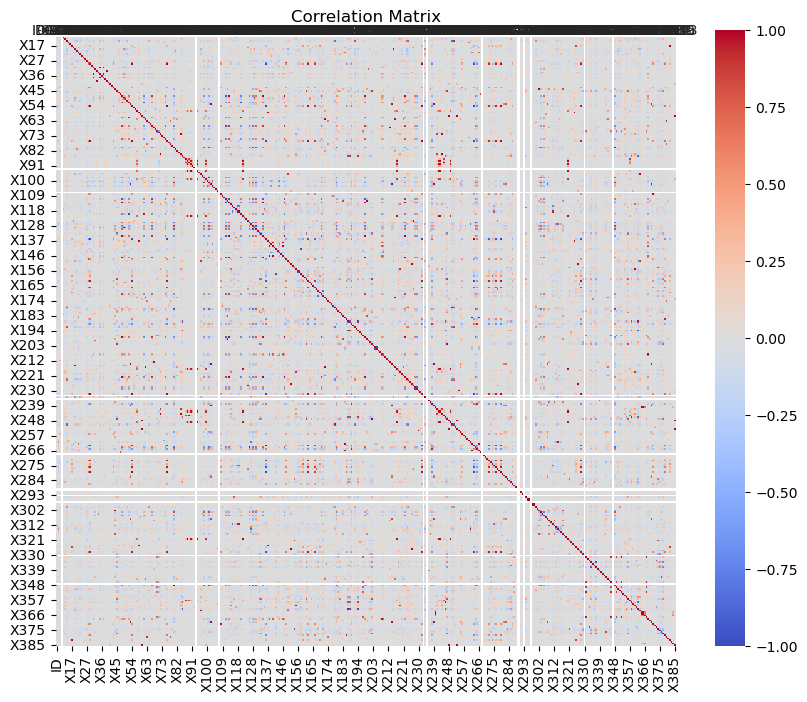

In [5]:
# Drop non-numeric columns
numeric_data = data.select_dtypes(include=['int', 'float'])
correlation_matrix = numeric_data.corr()

# Visualize correlations using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [6]:
#Removing highly correrelated variables from the data
# Compute the correlation matrix 
correlation_matrix = numeric_data.corr().abs()

upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
highly_correlated_pairs = [(column, col) for column in upper_triangle.columns
                           for col in upper_triangle.columns if column != col and upper_triangle[column][col] > 0.75]

# set to store columns to remove
columns_to_remove = set()

# Removing columns that are correlated with more than one column
for pair in highly_correlated_pairs:
    column1, column2 = pair
    if column1 not in columns_to_remove:
        columns_to_remove.add(column2)

# Remove the columns from the dataset
data_processed_filtered = numeric_data.drop(columns=columns_to_remove)

In [7]:
categorical_cols = [col for col in data.columns if col.startswith('X') and len(col) == 2]
data=pd.concat([data_processed_filtered,data[categorical_cols]], axis=1)

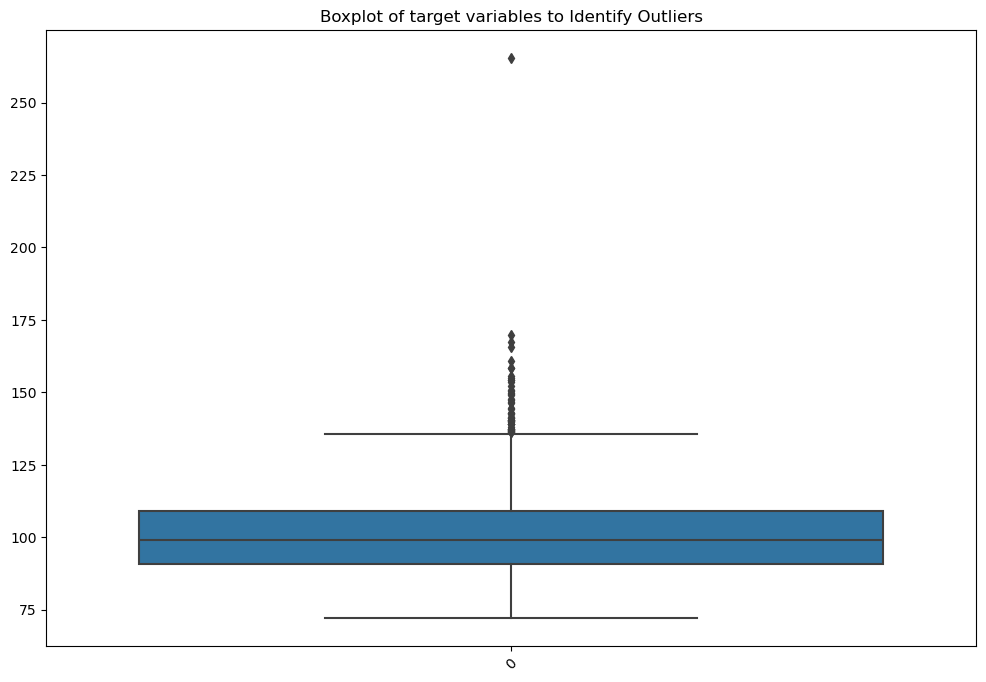

In [8]:
# Visualize boxplots for target variable to identify outliers
plt.figure(figsize=(12, 8))
sns.boxplot(data=data['y'])
plt.title('Boxplot of target variables to Identify Outliers')
plt.xticks(rotation=45)
plt.show()

In [9]:
#Removing Outliers from the data
lower_percentile = 1  
upper_percentile = 99  

# Calculate the percentile values for trimming
lower_limit = data['y'].quantile(lower_percentile / 100)
upper_limit = data['y'].quantile(upper_percentile / 100)

# Trim outliers
trimmed_data = data[(data['y'] >= lower_limit) & (data['y'] <= upper_limit)]

In [10]:
# Split data into features (X) and target variable (y)
X = trimmed_data.drop(['ID', 'y'], axis=1) 
y = trimmed_data['y']

In [11]:
# Identify categorical columns (X0 to X8 are single alphabets)
categorical_cols = [col for col in X.columns if col.startswith('X') and len(col) == 2]

# Perform one-hot encoding on categorical columns
encoder = OneHotEncoder(sparse=False, drop='first')  # Use drop='first' to avoid dummy variable trap
X_encoded = encoder.fit_transform(X[categorical_cols])

# Get feature names for the encoded columns
encoded_cols_names = [f"{col}_{val}" for col, categories in zip(categorical_cols, encoder.categories_) for val in categories[1:]]

# Create a DataFrame from the encoded data with appropriate column names
X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_cols_names)

# Align indices
X_encoded_df.index = X.index

# Concatenate the encoded categorical features with the numerical features
X_processed = pd.concat([X.drop(categorical_cols, axis=1), X_encoded_df], axis=1)

In [12]:
# Performing Dimentionality reduction
def dimension_red(X_processed, y, dimension_reduction_type='pca'):
    
    #PCA
    if dimension_reduction_type == 'pca':
        pca = PCA(n_components=0.85)
        X_reduced = pca.fit_transform(X_processed)
    
    ##Feature selection 
    elif dimension_reduction_type == 'fs': 
        percentile = 30  #retain the top 30% of features
        # feature selector based on F-value
        selector = SelectPercentile(score_func=f_regression, percentile=percentile)
        # Fitting the selector and transforming the data
        X_selected = selector.fit_transform(X_processed, y)
        # selected feature indices
        selected_indices = selector.get_support(indices=True)
        # names of the selected features
        selected_features = X_processed.columns[selected_indices]
        #transform X_processed to keep only the selected features
        X_reduced = X_processed[selected_features]
    
    #Feature extraction
    # Apply NMF for feature extraction
    elif dimension_reduction_type == 'nmf':
        percent_features = 0.3  # select top 30% features
        n_components = int(percent_features * X_processed.shape[1])
        # Initialize NMF for feature extraction
        nmf = NMF(n_components=n_components)
        X_reduced = nmf.fit_transform(X_processed)
    
    #auto encoders
    elif dimension_reduction_type=='autoencoder':
        model = Sequential([
            Dense(256, activation='relu', input_shape=(X_processed.shape[1],)),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dense(64, activation='relu'),
            Dense(128, activation='relu'),
            Dense(256, activation='relu'),
            Dense(X_processed.shape[1])  # Output layer
        ])
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_processed, X_processed, epochs=50, batch_size=32)
        encoder = Sequential(model.layers[:4])  # Encoder part
        X_reduced = encoder.predict(X_processed)

    else:
          raise ValueError("Invalid dimension_reduction_type. Use 'pca',,'fs','nmf' or 'autoencoder")
    return X_reduced

In [13]:
#Creating a function to train, evaluate and predict from the models 
def ML_models():
    # Define models
    model = {
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42), #Random Forest Model
        'KNN': KNeighborsRegressor(n_neighbors=5), #K-nearest neighbour model
        'Neural Network': MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', random_state=42), #Neural network model
        'Linear Regression': LinearRegression() #linear regression model
    }
    # Train and evaluate models
    for model_name, model in model.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        print(model_name,"R-squared Score:",r2)
        print(model_name,"MSE:",mse)
        mse_scores.append( mse)
        r2_scores.append(r2)

In [14]:
#Select the type of dimentionality reduction technique 

#X_reduced=dimension_red(X_processed, y, dimension_reduction_type='pca')
X_reduced=dimension_red(X_processed, y, dimension_reduction_type='fs')
#X_reduced=dimension_red(X_processed, y, dimension_reduction_type='nmf')
#X_reduced=dimension_red(X_processed, y, dimension_reduction_type='autoencoder')

In [15]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

In [16]:
# Initialize lists to store metrics
mse_scores = []
r2_scores = []

In [17]:
#Model for XGBOOST

In [18]:
# Convert data to DMatrix format for XGBoost
d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

# Define XGBoost parameters
params = {'objective': 'reg:squarederror','eta': 0.02,'max_depth': 4 }

# Define custom evaluation metric for R-squared
def xgb_r2score(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

watchlist = [(d_train, 'Train'), (d_test, 'Validation')]

# Train the XGBoost model
num_rounds = 1000
bst = xgb.train(params, d_train, num_rounds, watchlist, early_stopping_rounds=50,
                feval=xgb_r2score, maximize=True, verbose_eval=10)

[0]	Train-rmse:98.62423	Train-r2:-75.28325	Validation-rmse:98.30624	Validation-r2:-76.22777
[10]	Train-rmse:80.71371	Train-r2:-50.09242	Validation-rmse:80.43742	Validation-r2:-50.70440
[20]	Train-rmse:66.09592	Train-r2:-33.26188	Validation-rmse:65.85575	Validation-r2:-33.65762
[30]	Train-rmse:54.17398	Train-r2:-22.01671	Validation-rmse:53.96000	Validation-r2:-22.26779
[40]	Train-rmse:44.46094	Train-r2:-14.50312	Validation-rmse:44.26768	Validation-r2:-14.65975
[50]	Train-rmse:36.56022	Train-r2:-9.48286	Validation-rmse:36.38441	Validation-r2:-9.57894
[60]	Train-rmse:30.14794	Train-r2:-6.12816	Validation-rmse:29.98765	Validation-r2:-6.18615
[70]	Train-rmse:24.96096	Train-r2:-3.88635	Validation-rmse:24.81341	Validation-r2:-3.92021
[80]	Train-rmse:20.78488	Train-r2:-2.38810	Validation-rmse:20.64697	Validation-r2:-2.40662
[90]	Train-rmse:17.44450	Train-r2:-1.38660	Validation-rmse:17.31457	Validation-r2:-1.39571
[100]	Train-rmse:14.79602	Train-r2:-0.71693	Validation-rmse:14.67644	Validation-r

In [19]:
# Make predictions
y_pred = bst.predict(d_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("XGBOOST R-squared score:", r2)
print("Mean Squared Error:",mse)
# Store metrics
mse_scores.append(mse)
r2_scores.append(r2)

XGBOOST R-squared score: 0.6247554588091988
Mean Squared Error: 46.957298145625714


In [20]:
#Running all the models to give the R^2 and MSE for each model
ML_models()

Random Forest R-squared Score: 0.5080836556133825
Random Forest MSE: 61.55735769737281
KNN R-squared Score: 0.5376816669189521
KNN MSE: 57.85352595878787
Neural Network R-squared Score: 0.5359617000121137
Neural Network MSE: 58.06875893350009
Linear Regression R-squared Score: 0.5884851788663592
Linear Regression MSE: 51.496083290098255


Models: ['XGBoost', 'Random Forest', 'KNN', 'Neural Networks', 'Linear Regression']
R-squared: [0.6247554588091988, 0.5080836556133825, 0.5376816669189521, 0.5359617000121137, 0.5884851788663592]
MSE: [46.957298145625714, 61.55735769737281, 57.85352595878787, 58.06875893350009, 51.496083290098255]


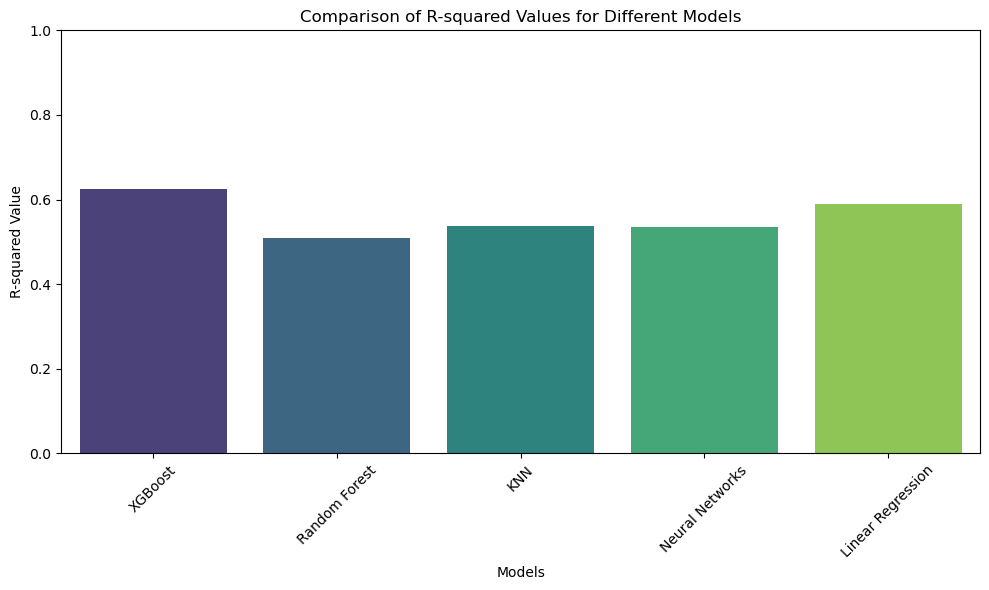

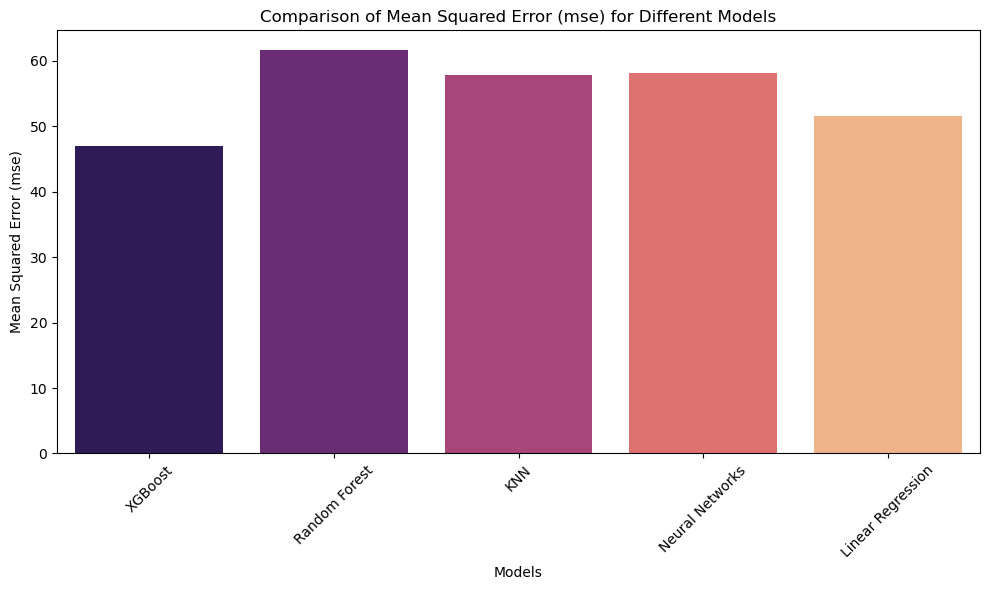

In [21]:
# Model Comparison- Visualisation
models = ['XGBoost', 'Random Forest', 'KNN', 'Neural Networks','Linear Regression']

# Printing the array for the models and their respective R^2 and MSE values
print("Models:", models)
print("R-squared:", r2_scores)
print("MSE:", mse_scores)

# Plotting R^2 values
plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=r2_scores, palette='viridis')
plt.title('Comparison of R-squared Values for Different Models')
plt.xlabel('Models')
plt.ylabel('R-squared Value')
plt.ylim(0, 1) 
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

# Plotting mse values
plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=mse_scores, palette='magma')
plt.title('Comparison of Mean Squared Error (mse) for Different Models')
plt.xlabel('Models')
plt.ylabel('Mean Squared Error (mse)')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()